In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as dt

## Step 1

Let us download the data for the Titan stock

In [18]:
stock_data = yf.Ticker("TITAN.NS").history(start="2017-01-01", end="2024-12-31")

In [19]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+05:30,3378.100098,3406.300049,3336.649902,3396.949951,691202,0.0,0.0
2024-12-24 00:00:00+05:30,3385.350098,3419.000000,3338.199951,3353.399902,485245,0.0,0.0
2024-12-26 00:00:00+05:30,3365.000000,3371.850098,3312.649902,3323.050049,637094,0.0,0.0


In [25]:
stock_data.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0


Let us consider the closing prices for the analysis and model building to follow.

In [28]:
stock_prices = stock_data["Close"]

Let us perform some exploratory analysis on the closing prices.

In [31]:
stock_prices.describe() #summary statistics

count    1974.000000
mean     1777.024130
std      1020.301013
min       320.298187
25%       905.107513
50%      1420.720703
75%      2562.747559
max      3854.039062
Name: Close, dtype: float64

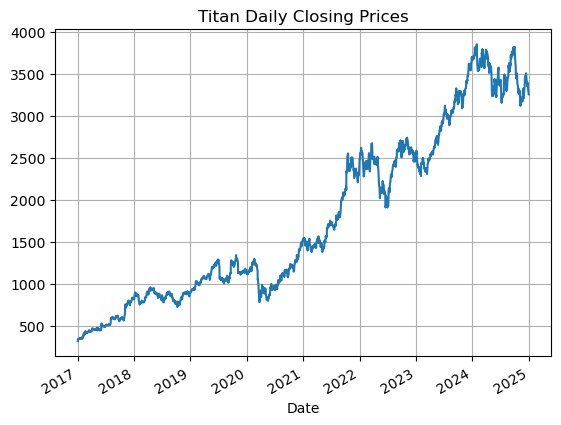

In [37]:
stock_prices.plot()
plt.title("Titan Daily Closing Prices")
plt.grid()

Despite some prices corrections, there appears to be a general rising trend in this stock over the years

Let us now look at the skew and kurtosis.

In [41]:
stock_prices.skew()

0.4788396459924155

In [43]:
stock_prices.kurtosis()

-1.1356475289698953

Let us now check for stationarity

In [48]:
adf_result = adfuller(stock_prices)
adf_statistic = adf_result[0] 
p_value = adf_result[1]
used_lags = adf_result[2] 
critical_values = adf_result[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.6927549164710374,
 0.8486172629177092,
 4,
 {'1%': -3.433675467561267,
  '5%': -2.863008999826203,
  '10%': -2.5675520348463654})

The series is not stationary, as the p-value is greater than 0.05. The ADF statistic is also higher than all critical values.

Let us check for the presence of persistence in the series

In [52]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(stock_prices.autocorr(lag = i))

0.9995098501235516
0.9974090942183587
0.994880270373017
0.9763846324044606
0.9581783377427333
0.9292831670282055
0.9138901418023251
0.8339297669499727


Clearly, high autocorrelation is present in the stock.

Text(0.5, 1.0, 'Histogram of Titan Closing Prices')

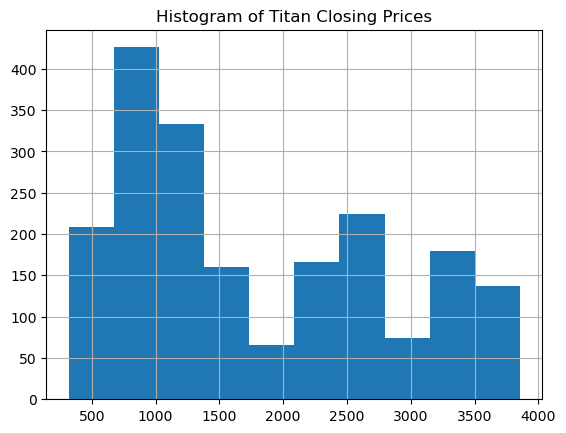

In [57]:
stock_prices.hist()
plt.title("Histogram of Titan Closing Prices")